# This file is a cleaned-up version of Duffing_oscillator

In [1]:
import numpy as np
# from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.signal import chirp
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial # Import this due to weird lambda behavior
import system_dynamics
import networks
%load_ext tensorboard

## Training data generation

In [3]:
t0 = 0
t1 = 20
dt = 0.01
duffing_sys = system_dynamics.Duffing(t0=t0, tf=t1, dt=dt, noise=0)
# Make some data generation input functions
duffing_sys.add_u_func( [partial(chirp, f0=0.9, f1=1.1, t1=1)] )
ts_steps = np.arange(t0, t1, dt)
duffing_sys.add_u_func( [interp1d( 
    ts_steps, np.random.normal(0, 2, ts_steps.shape), fill_value="extrapolate", kind='cubic')] )
duffing_sys.add_u_func( 
    [interp1d( ts_steps, np.random.normal(0, 2, ts_steps.shape), fill_value="extrapolate", kind='cubic')] )
duffing_sys.add_u_func( 
    [interp1d( ts_steps, np.random.normal(0, 2, ts_steps.shape), fill_value="extrapolate", kind='cubic')] )
u_names = ['Chirp','rand1','rand2','rand3']

# Generate data
duffing_sys.data_generator()


## Plot the generated data for visual inspection

In [ ]:
fig,axs = duffing_sys.plot_dataset(title='Training and test data', plot_skip_rate=1)

## Generate a bunch of neural nets for learning

In [142]:
# Set up nets
tf.keras.backend.clear_session()
input_mask = [0,1,3] #[1,2]
seed = 2020
opt_alg = 'sgd'
net_original = networks.NN_Dense(
    duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/original', tensorboard=True, 
    Nlayer=2, Nneuron=[15,10], activation='tanh', optimizer=opt_alg)
net_25 = networks.NN_Dense(
    duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/2-5', 
    Nlayer=2, Nneuron=5, activation='tanh', optimizer=opt_alg)
net_22 = networks.NN_Dense(
    duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/2-2', 
    Nlayer=2, Nneuron=2, activation='tanh', optimizer=opt_alg)
net_42 = networks.NN_Dense(
    duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/4-2', 
    Nlayer=4, Nneuron=2, activation='tanh', optimizer=opt_alg)
net_44 = networks.NN_Dense(
    duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/4-4', 
    Nlayer=4, Nneuron=4, activation='tanh', optimizer=opt_alg)
net_list = [net_original, net_25, net_22, net_42, net_44]
net_names = ['original','2-5','2-2','4-2','4-4']

# Construct models
for nn in net_list:
    nn.construct()


In [51]:
# Train models. Only the chirp was used to train in the original implementation.
Epoch = 200
for nn in net_list:
    nn.train(epoch=Epoch, inds=[1,2])
    nn.summary()

Train on 3998 samples
Epoch 1/200
3998/3998 [==============================] - 1s 161us/sample - loss: 0.1614
Epoch 2/200
3998/3998 [==============================] - 0s 35us/sample - loss: 0.1555
Epoch 3/200
3998/3998 [==============================] - 0s 33us/sample - loss: 0.1521
Epoch 4/200
3998/3998 [==============================] - 0s 34us/sample - loss: 0.1493
Epoch 5/200
3998/3998 [==============================] - 0s 47us/sample - loss: 0.1469
Epoch 6/200
3998/3998 [==============================] - 0s 52us/sample - loss: 0.1451
Epoch 7/200
3998/3998 [==============================] - 0s 38us/sample - loss: 0.1434
Epoch 8/200
3998/3998 [==============================] - 0s 35us/sample - loss: 0.1416
Epoch 9/200
3998/3998 [==============================] - 0s 34us/sample - loss: 0.1403
Epoch 10/200
3998/3998 [==============================] - 0s 34us/sample - loss: 0.1391
Epoch 11/200
3998/3998 [==============================] - 0s 36us/sample - loss: 0.1380
Epoch 12/200
3998/

## Validation and testing

In [7]:
# Additional training, if needed
# net_list[3].train(epoch=Epoch, inds=[0])

Train on 1999 samples
Epoch 1/100
1999/1999 [==============================] - 0s 66us/sample - loss: 0.0061
Epoch 2/100
1999/1999 [==============================] - 0s 41us/sample - loss: 0.0060
Epoch 3/100
1999/1999 [==============================] - 0s 40us/sample - loss: 0.0060
Epoch 4/100
1999/1999 [==============================] - 0s 41us/sample - loss: 0.0061
Epoch 5/100
1999/1999 [==============================] - 0s 45us/sample - loss: 0.0060
Epoch 6/100
1999/1999 [==============================] - 0s 46us/sample - loss: 0.0060
Epoch 7/100
1999/1999 [==============================] - 0s 46us/sample - loss: 0.0060
Epoch 8/100
1999/1999 [==============================] - 0s 42us/sample - loss: 0.0060
Epoch 9/100
1999/1999 [==============================] - 0s 41us/sample - loss: 0.0059
Epoch 10/100
1999/1999 [==============================] - 0s 40us/sample - loss: 0.0059
Epoch 11/100
1999/1999 [==============================] - 0s 40us/sample - loss: 0.0059
Epoch 12/100
1999/1

Text(0.5, 0.98, 'Performance when given <u,v> as training input, after 200 SGD epochs (no momentum)\n\n')

<Figure size 432x288 with 0 Axes>

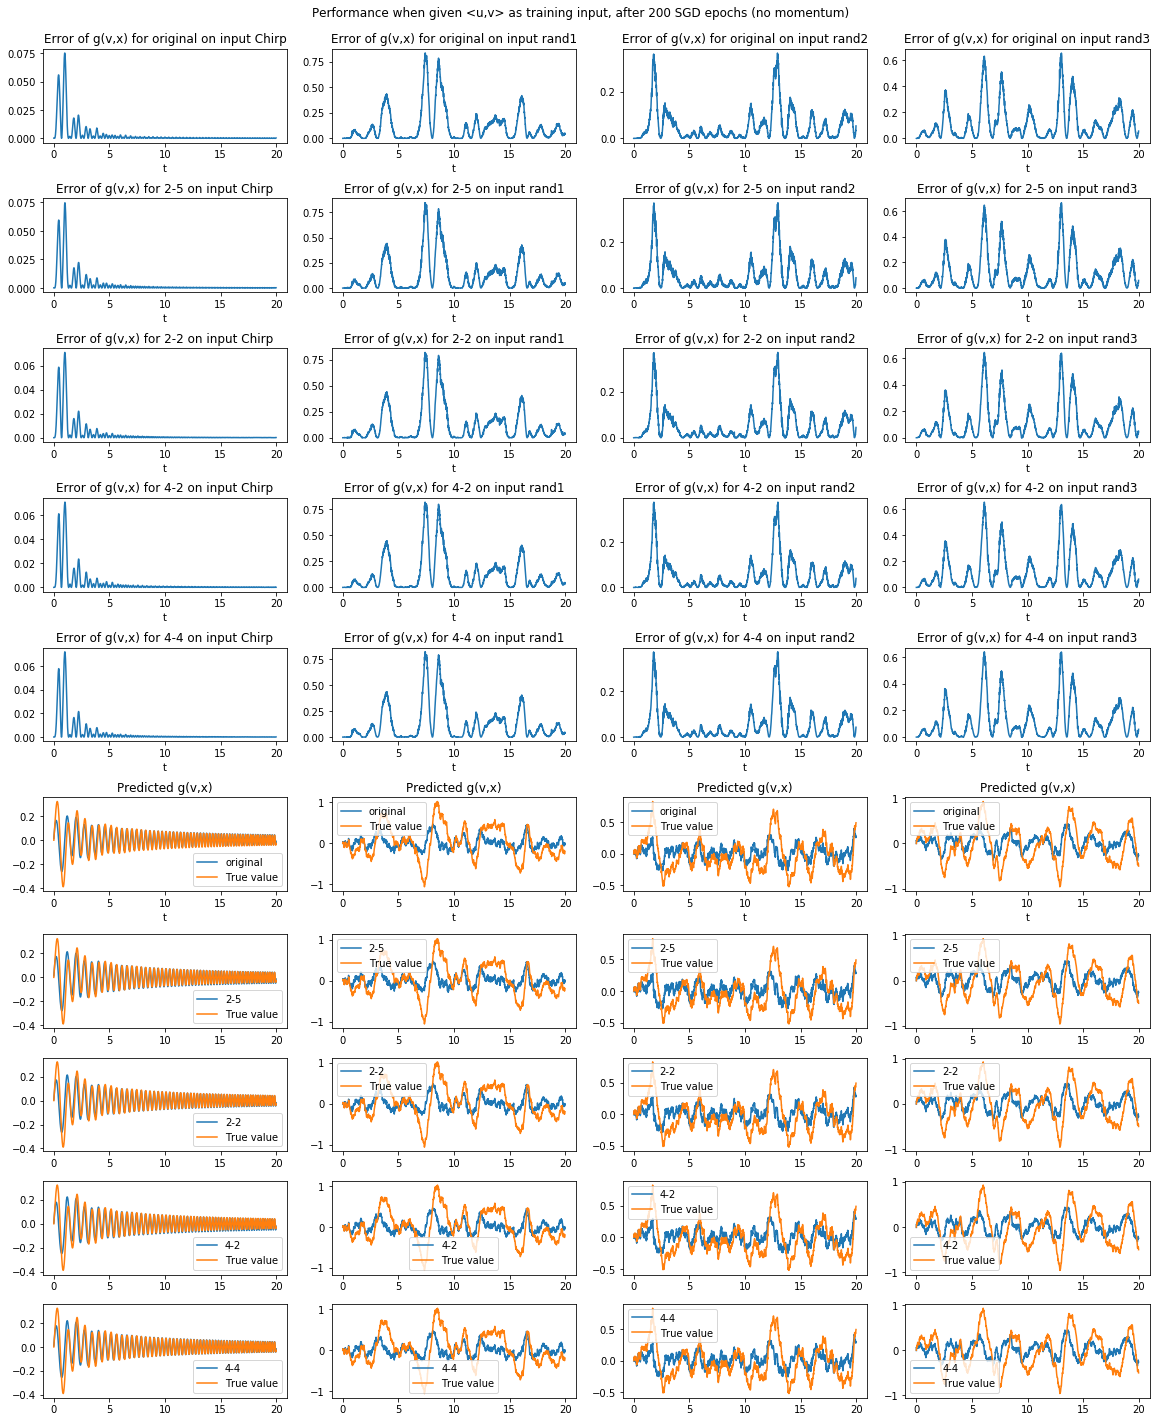

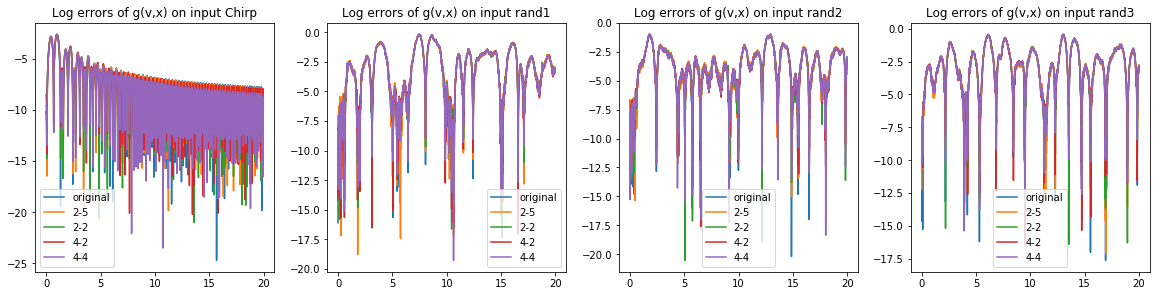

In [52]:
results_list = [nn.test(inds=[0,1,2,3]) for nn in net_list]
# Notice: Prediction size is (N,1), while output size is (N,1,1)

# Use our own plots instead...
# * It is possible to control and unify the plot axis ranges by: axs[][].set(xlim=(xmin, xmax), ylim=(ymin, ymax))
plt.clf()
Nrow = 2 * (len(net_list)) 
Ncol = 4
fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (Ncol*4,Nrow*2), squeeze=False)
figt,axst = plt.subplots(1, Ncol, constrained_layout=True, figsize = (Ncol*4,4))
plot_skip_rate = 1
for j in range(Ncol):
    time_series = results_list[0][2][j][:,0,-1] # [:,0,-1] means take all frames(:), first row (0), latest value (-1)
    #for i in range(Nrow):
    for n in range(len(net_list)):
        # Plot error between correct answer and prediction
        error_g = np.square(results_list[n][0][j] - results_list[n][1][j])
        axs[n][j].plot(time_series[::plot_skip_rate], error_g[::plot_skip_rate])
        axs[n][j].set_title('Error of g(v,x) for '+net_names[n]+' on input '+u_names[j])
        axs[n][j].set_xlabel('t')
        axs[n+len(net_list)][j].plot(time_series[::plot_skip_rate], results_list[n][0][j][::plot_skip_rate])
        axs[n+len(net_list)][j].plot(time_series[::plot_skip_rate], results_list[n][1][j][::plot_skip_rate])
        axs[n+len(net_list)][j].legend([net_names[n]]+['True value'])
        axst[j].plot(time_series[::plot_skip_rate], np.log(error_g[::plot_skip_rate]))
#     axs[0][j].set_title('log Error of g(v,x)')
#     axs[0][j].set_xlabel('t')
    axs[len(net_list)][j].set_title('Predicted g(v,x)')
    axs[len(net_list)][j].set_xlabel('t')
    axst[j].set_title('Log errors of g(v,x) on input '+u_names[j])
    axst[j].legend(net_names)
#     axs[len(net_list)][j].plot(time_series[::plot_skip_rate], results_list[n][1][j][::plot_skip_rate])
#     axs[0][j].legend(['Original','2-5','2-2','4-2','4-4'])
#     axs[len(net_list)][j].legend(['Original','2-5','2-2','4-2','4-4','true model'])
fig.suptitle('Performance when given <u,v> as training input, after 200 SGD epochs (no momentum)\n\n') # Without \n, it will overlap

In [ ]:
# Weight inspection
for nn in net_list:
    nn.weights()

## Now, test only providing <u,v>, or <u,x>.

In [143]:
# Resetting the input index to only allow u(t) and v(t) as input
for nn in net_list:
    nn.set_input_mask([3]) # 1 for v, 2 for x, 3 for u

In [144]:
# Train models. Only the chirp was used to train in the original implementation ([0]), but
# feel free to switch their roles of training and testing.
Epoch = 200
for nn in net_list:
    nn.train(epoch=Epoch, inds=[1,2])
    nn.summary()

Train on 3998 samples
Epoch 1/200
3998/3998 [==============================] - 1s 291us/sample - loss: 0.1525
Epoch 2/200
3998/3998 [==============================] - 0s 37us/sample - loss: 0.1500
Epoch 3/200
3998/3998 [==============================] - 0s 35us/sample - loss: 0.1497
Epoch 4/200
3998/3998 [==============================] - 0s 32us/sample - loss: 0.1494
Epoch 5/200
3998/3998 [==============================] - 0s 33us/sample - loss: 0.1490
Epoch 6/200
3998/3998 [==============================] - 0s 35us/sample - loss: 0.1490
Epoch 7/200
3998/3998 [==============================] - 0s 30us/sample - loss: 0.1490
Epoch 8/200
3998/3998 [==============================] - 0s 31us/sample - loss: 0.1485
Epoch 9/200
3998/3998 [==============================] - 0s 31us/sample - loss: 0.1484
Epoch 10/200
3998/3998 [==============================] - 0s 31us/sample - loss: 0.1482
Epoch 11/200
3998/3998 [==============================] - 0s 32us/sample - loss: 0.1480
Epoch 12/200
3998/

In [ ]:
# Special training... change seed for any unfortunate model, and retrain.
# net_list[3].seed = 33
# net_list[3].set_input_mask([1,3])
net_list[3].train(epoch=100, inds=[0])

Text(0.5, 0.98, 'Performance when given <u,x> as training input, after 400 SGD epochs\n\n')

<Figure size 432x288 with 0 Axes>

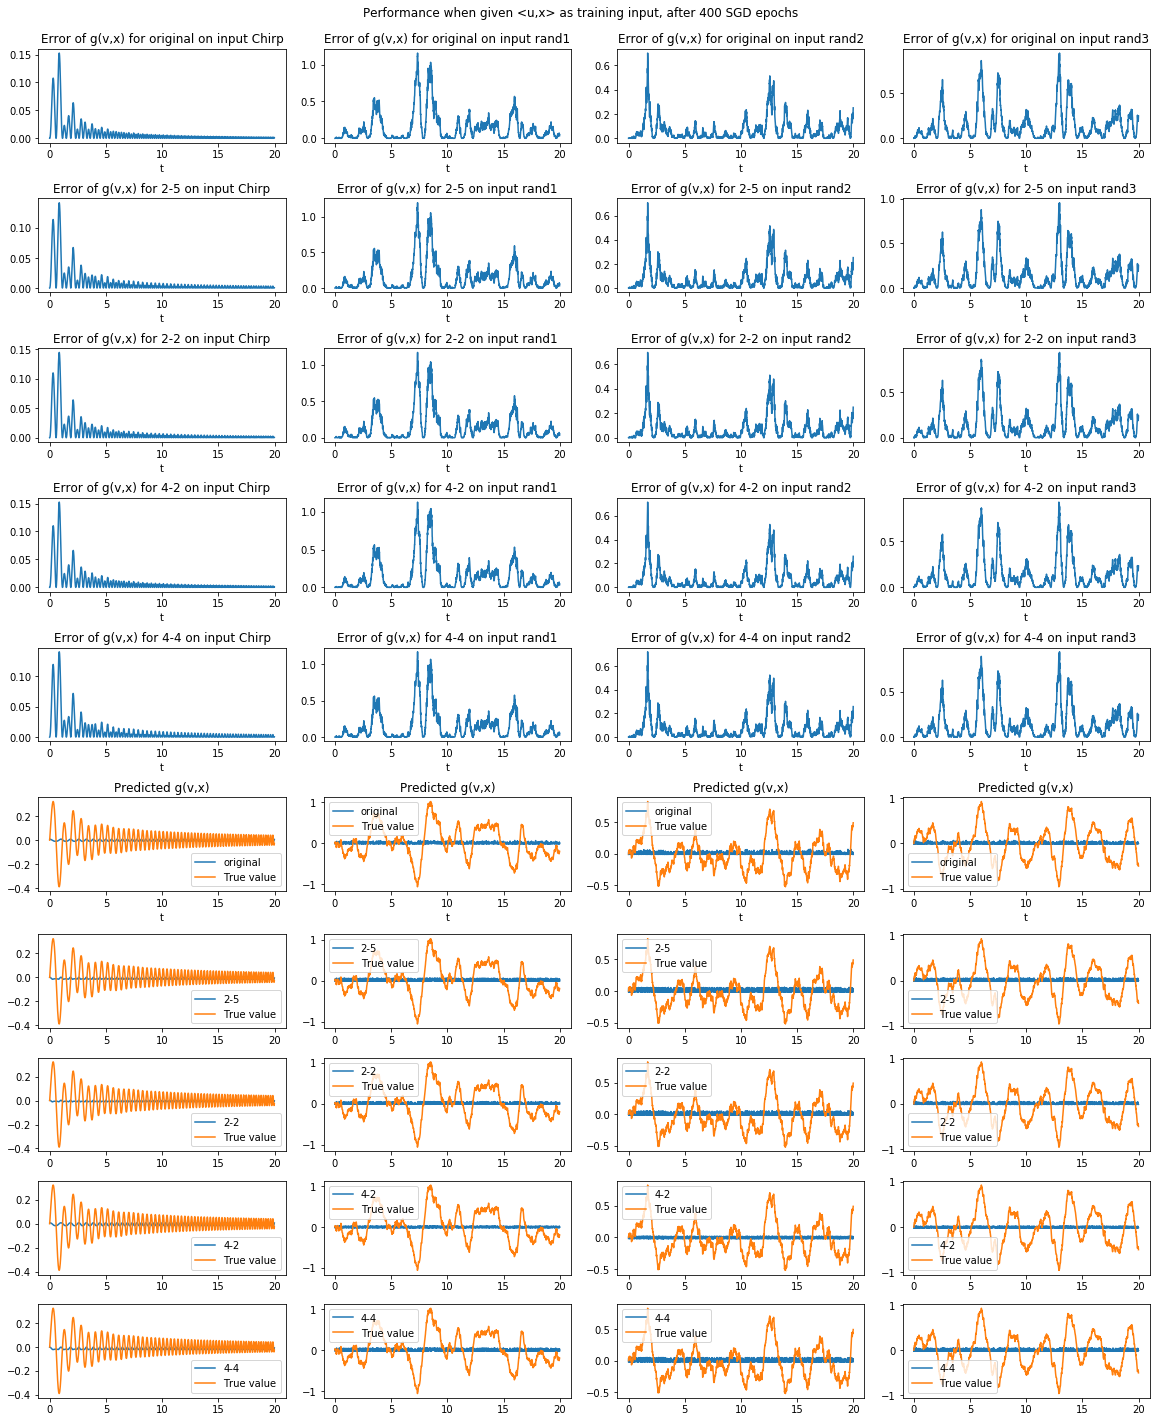

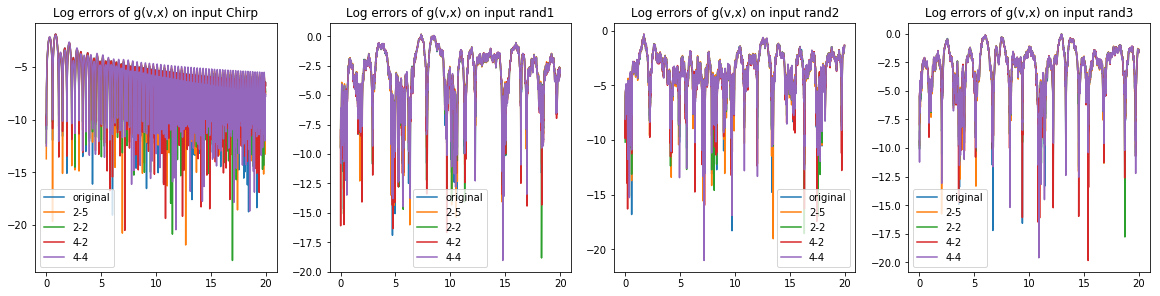

In [145]:
results_list = [nn.test(inds=[0,1,2,3]) for nn in net_list]
# Notice: Prediction size is (N,1), while output size is (N,1,1)

# Use our own plots instead...
# * It is possible to control and unify the plot axis ranges by: axs[][].set(xlim=(xmin, xmax), ylim=(ymin, ymax))
plt.clf()
Nrow = 2 * (len(net_list)) 
Ncol = 4
fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (Ncol*4,Nrow*2), squeeze=False)
figt,axst = plt.subplots(1, Ncol, constrained_layout=True, figsize = (Ncol*4,4))
plot_skip_rate = 1
for j in range(Ncol):
    time_series = results_list[0][2][j][:,0,-1] # [:,0,-1] means take all frames(:), first row (0), latest value (-1)
    #for i in range(Nrow):
    for n in range(len(net_list)):
        # Plot error between correct answer and prediction
        error_g = np.square(results_list[n][0][j] - results_list[n][1][j])
        axs[n][j].plot(time_series[::plot_skip_rate], error_g[::plot_skip_rate])
        axs[n][j].set_title('Error of g(v,x) for '+net_names[n]+' on input '+u_names[j])
        axs[n][j].set_xlabel('t')
        axs[n+len(net_list)][j].plot(time_series[::plot_skip_rate], results_list[n][0][j][::plot_skip_rate])
        axs[n+len(net_list)][j].plot(time_series[::plot_skip_rate], results_list[n][1][j][::plot_skip_rate])
        axs[n+len(net_list)][j].legend([net_names[n]]+['True value'])
        axst[j].plot(time_series[::plot_skip_rate], np.log(error_g[::plot_skip_rate]))
#     axs[0][j].set_title('log Error of g(v,x)')
#     axs[0][j].set_xlabel('t')
    axs[len(net_list)][j].set_title('Predicted g(v,x)')
    axs[len(net_list)][j].set_xlabel('t')
    axst[j].set_title('Log errors of g(v,x) on input '+u_names[j])
    axst[j].legend(net_names)
#     axs[len(net_list)][j].plot(time_series[::plot_skip_rate], results_list[n][1][j][::plot_skip_rate])
#     axs[0][j].legend(['Original','2-5','2-2','4-2','4-4'])
#     axs[len(net_list)][j].legend(['Original','2-5','2-2','4-2','4-4','true model'])
fig.suptitle('Performance when given <u,x> as training input, after 400 SGD epochs\n\n')

## Try to use the gradual training method

In [83]:
# from importlib import reload
reload(system_dynamics)
reload(networks)

<module 'networks' from '/Users/zz/Documents/GT 20X/phml/NN_toy_examples/networks.py'>

In [80]:
# Set up nets
tf.keras.backend.clear_session()
input_mask = [1,3] #[1,2]
seed = 2020
opt_alg = 'sgd'
net_original = networks.NN_Dense(
    duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/original', tensorboard=True, 
    Nlayer=2, Nneuron=[15,10], activation='tanh', optimizer=opt_alg)
net_25 = networks.NN_Dense(
    duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/2-5', 
    Nlayer=2, Nneuron=5, activation='tanh', optimizer=opt_alg)
net_22 = networks.NN_Dense(
    duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/2-2', 
    Nlayer=2, Nneuron=2, activation='tanh', optimizer=opt_alg)
net_42 = networks.NN_Dense(
    duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/4-2', 
    Nlayer=4, Nneuron=2, activation='tanh', optimizer=opt_alg)
net_44 = networks.NN_Dense(
    duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/4-4', 
    Nlayer=4, Nneuron=4, activation='tanh', optimizer=opt_alg)
net_list = [net_original, net_25, net_22, net_42, net_44]
net_names = ['original','2-5','2-2','4-2','4-4']

# Construct models
for nn in net_list:
    nn.construct()

In [81]:
# Train models. Only the chirp was used to train in the original implementation.
max_epoch = 400
for nn in net_list:
    nn.batch_train(max_epoch=max_epoch, inds=[0,1], tolerance=0.01, random=False) # [0] is chirp; [1-3] are the rest
    nn.summary()

Train on 399 samples
399/399 [==============================] - 1s 1ms/sample - loss: 0.0884
Train on 399 samples
Epoch 1/10
399/399 [==============================] - 0s 102us/sample - loss: 0.0811
Epoch 2/10
399/399 [==============================] - 0s 69us/sample - loss: 0.0794
Epoch 3/10
399/399 [==============================] - 0s 60us/sample - loss: 0.0785
Epoch 4/10
399/399 [==============================] - 0s 84us/sample - loss: 0.0776
Epoch 5/10
399/399 [==============================] - 0s 65us/sample - loss: 0.0769
Epoch 6/10
399/399 [==============================] - 0s 58us/sample - loss: 0.0760
Epoch 7/10
399/399 [==============================] - 0s 68us/sample - loss: 0.0751
Epoch 8/10
399/399 [==============================] - 0s 59us/sample - loss: 0.0745
Epoch 9/10
399/399 [==============================] - 0s 54us/sample - loss: 0.0737
Epoch 10/10
399/399 [==============================] - 0s 57us/sample - loss: 0.0730
Trained for 10 epochs for batch 9\%
Train on

Text(0.5, 0.98, 'Performance when given <u,v> as training input, after gradual SGD epochs (no momentum)\n\n')

<Figure size 432x288 with 0 Axes>

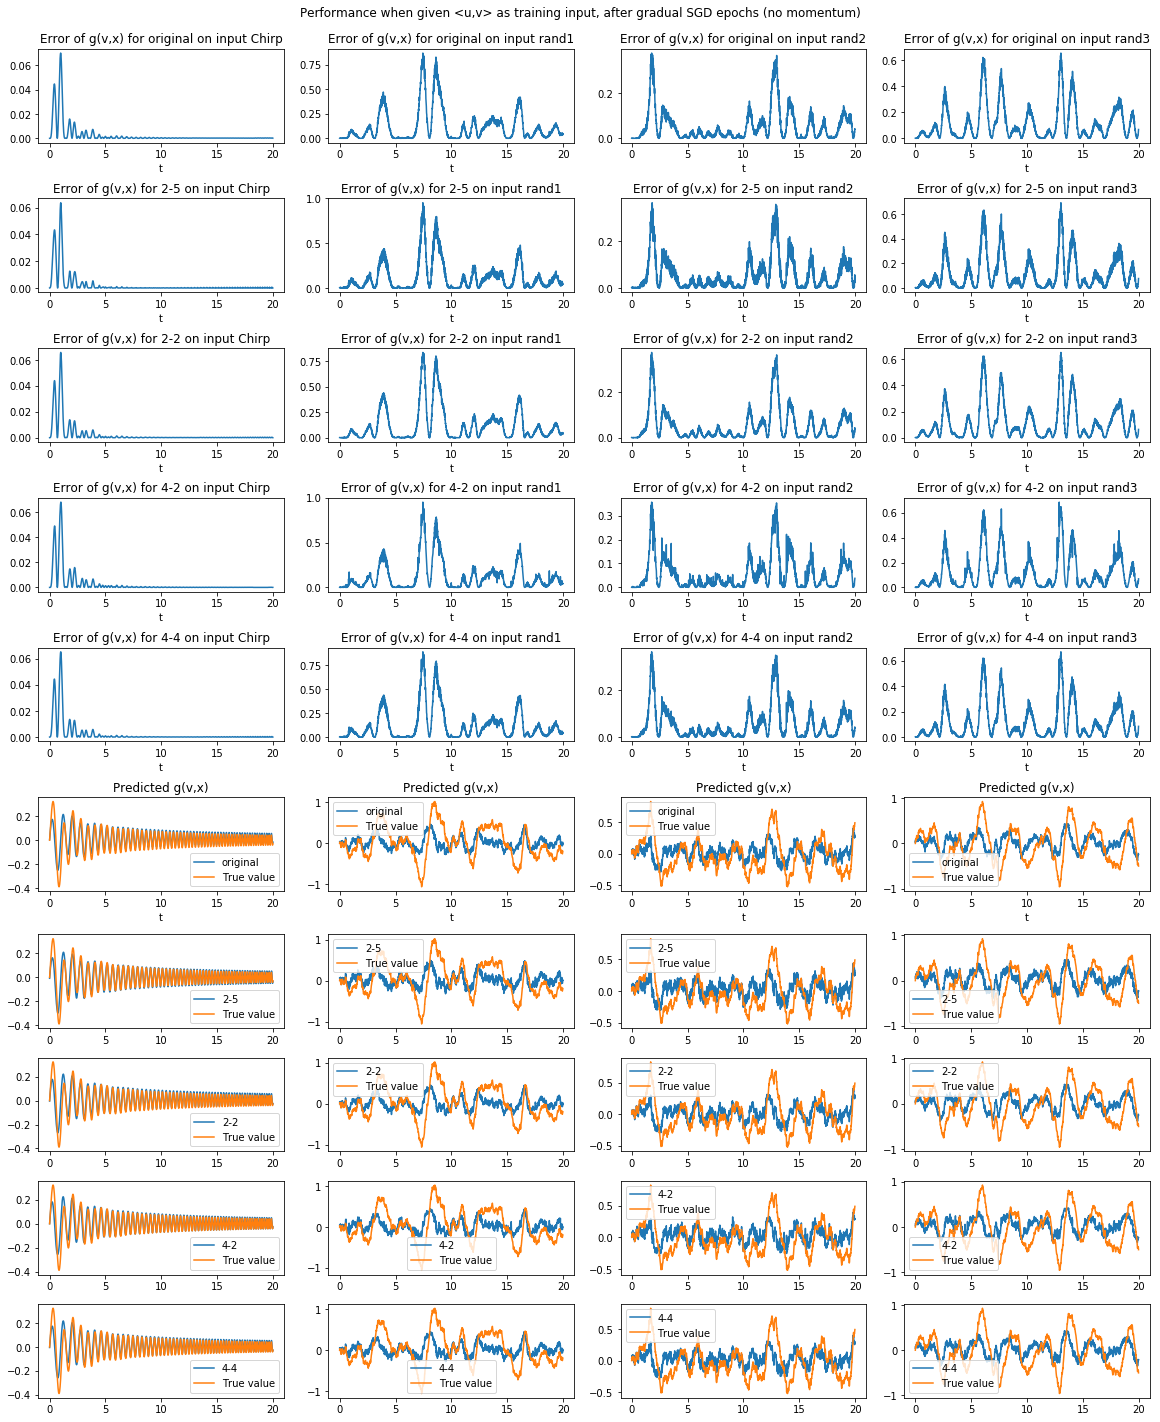

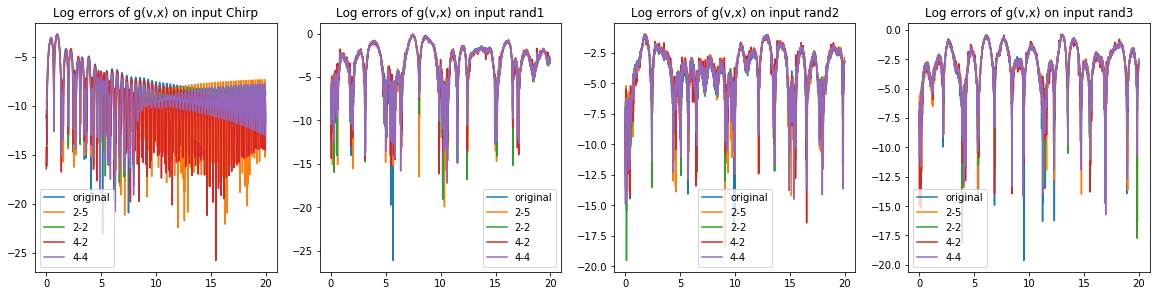

In [82]:
results_list = [nn.test(inds=[0,1,2,3]) for nn in net_list]
# Notice: Prediction size is (N,1), while output size is (N,1,1)

# Use our own plots instead...
# * It is possible to control and unify the plot axis ranges by: axs[][].set(xlim=(xmin, xmax), ylim=(ymin, ymax))
plt.clf()
Nrow = 2 * (len(net_list)) 
Ncol = 4
fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (Ncol*4,Nrow*2), squeeze=False)
figt,axst = plt.subplots(1, Ncol, constrained_layout=True, figsize = (Ncol*4,4))
plot_skip_rate = 1
for j in range(Ncol):
    time_series = results_list[0][2][j][:,0,-1] # [:,0,-1] means take all frames(:), first row (0), latest value (-1)
    for n in range(len(net_list)):
        # Plot error between correct answer and prediction
        error_g = np.square(results_list[n][0][j] - results_list[n][1][j])
        axs[n][j].plot(time_series[::plot_skip_rate], error_g[::plot_skip_rate])
        axs[n][j].set_title('Error of g(v,x) for '+net_names[n]+' on input '+u_names[j])
        axs[n][j].set_xlabel('t')
        axs[n+len(net_list)][j].plot(time_series[::plot_skip_rate], results_list[n][0][j][::plot_skip_rate])
        axs[n+len(net_list)][j].plot(time_series[::plot_skip_rate], results_list[n][1][j][::plot_skip_rate])
        axs[n+len(net_list)][j].legend([net_names[n]]+['True value'])
        axst[j].plot(time_series[::plot_skip_rate], np.log(error_g[::plot_skip_rate]))
    axs[len(net_list)][j].set_title('Predicted g(v,x)')
    axs[len(net_list)][j].set_xlabel('t')
    axst[j].set_title('Log errors of g(v,x) on input '+u_names[j])
    axst[j].legend(net_names)
fig.suptitle('Performance when given <u,v> as training input, after gradual SGD epochs (no momentum)\n\n')

## Try to animate the evolution of loss (do it later)

In [134]:
# from importlib import reload
reload(system_dynamics)
reload(networks)

<module 'networks' from '/Users/zz/Documents/GT 20X/phml/NN_toy_examples/networks.py'>

In [135]:
# Set up nets
tf.keras.backend.clear_session()
input_mask = [1,3] #[1,2]
seed = 2020
opt_alg = 'sgd'
net_original = networks.NN_Dense(
    duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/original', tensorboard=True, 
    Nlayer=2, Nneuron=[15,10], activation='tanh', optimizer=opt_alg)
# net_25 = networks.NN_Dense(
#     duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/2-5', 
#     Nlayer=2, Nneuron=5, activation='tanh', optimizer=opt_alg)
# net_22 = networks.NN_Dense(
#     duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/2-2', 
#     Nlayer=2, Nneuron=2, activation='tanh', optimizer=opt_alg)
# net_42 = networks.NN_Dense(
#     duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/4-2', 
#     Nlayer=4, Nneuron=2, activation='tanh', optimizer=opt_alg)
# net_44 = networks.NN_Dense(
#     duffing_sys, input_mask, seed=seed, log_dir='Duffing_logs/4-4', 
#     Nlayer=4, Nneuron=4, activation='tanh', optimizer=opt_alg)
net_list = [net_original]#, net_25, net_22, net_42, net_44]
net_names = ['original']#,'2-5','2-2','4-2','4-4']

# Construct models
for nn in net_list:
    nn.construct()

In [136]:
# Train models. Only the chirp was used to train in the original implementation.
epoch = 50
for nn in net_list:
    nn.train_and_store_pred(epoch, [0,1]) # [0] is chirp; [1-3] are the rest
    nn.summary()

Train on 3998 samples
Epoch 1/10
3998/3998 [==============================] - 15s 4ms/sample - loss: 0.1304
Epoch 2/10
3998/3998 [==============================] - 0s 73us/sample - loss: 0.1263
Epoch 3/10
3998/3998 [==============================] - 0s 50us/sample - loss: 0.1234
Epoch 4/10
3998/3998 [==============================] - 0s 48us/sample - loss: 0.1213
Epoch 5/10
3998/3998 [==============================] - 0s 50us/sample - loss: 0.1198
Epoch 6/10
3998/3998 [==============================] - 0s 62us/sample - loss: 0.1180
Epoch 7/10
3998/3998 [==============================] - 0s 48us/sample - loss: 0.1166
Epoch 8/10
3998/3998 [==============================] - 0s 52us/sample - loss: 0.1153
Epoch 9/10
3998/3998 [==============================] - 0s 45us/sample - loss: 0.1141
Epoch 10/10
3998/3998 [==============================] - 0s 45us/sample - loss: 0.1132
Train on 3998 samples
Epoch 1/10
3998/3998 [==============================] - 0s 50us/sample - loss: 0.1124
Epoch 2/1

In [ ]:
# Plot one of the training histories
(fig,axs,anim0,anim1) = net_list[0].plot_predictions()

In [ ]:
anim1.save('test.gif')

In [ ]:
(Inputset, Outputset) = net_original.dynamics.take_dataset([1])
(Inputset, Outputset) = net_original.dynamics.framing(input_data=Inputset, output_data=Outputset)
# Put all data into one array, so that it could train
Inputset = np.concatenate(Inputset)
Outputset = np.concatenate(Outputset)
Inputset = Inputset[:,[2,3],:]

In [ ]:
# plt.plot(time_series,np.squeeze(Outputset))
plt.plot(time_series,np.squeeze(Inputset[:,0]))

In [ ]:
model.get_layer('dense_2').output

In [ ]:
%tensorboard --logdir Duffing_logs/original